In [1]:
import torch
from scipy.io.arff import loadarff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime


from diffusion import *

import config
from config import *

import torch
from torch import nn, einsum
import torch.nn.functional as F

from torch.utils.data import DataLoader

import json

import random



In [2]:
def split_classe(x, y, query_class, target_class):
    """
    Split the dataset between the series of query class and series of the target class
    Args:
        x: Dataset
        y: Class attributed to each element in the dataset
        query_class: List of the query class
        target_class: List of the target class

    Returns: the split dataset

    """
    x = x.astype(np.float32)
    query = []
    query_y = []
    target = []
    target_y = []
    for i in range(len(x)):
        if y[i] in query_class:
            query.append(x.values[i])
            query_y.append(y[i]-1)
        elif y[i] in target_class:
            target.append(x.values[i])
            target_y.append(y[i]-1)

    query = np.array(query)
    target = np.array(target)
    query_y = np.array(query_y)
    target_y = np.array(target_y)
    query = torch.tensor(query)
    target = torch.tensor(target)

    print("query : ", query.shape)
    print("target : ", target.shape)
    return query, target, query_y, target_y


def loaddata_arff(dataset_name, batchsize):
    """
    Load a whole .arff dataset
    Args:
        dataset_name: name of the .arff file (Must provide a TRAIN and a TEST file)
        batchsize: Size of the batch
        query_class: List of the query class
        target_class: List of the target class

    Returns: Split datasets between train/test and query/target

    """
    train = loadarff("datasets/"+dataset_name+"_TRAIN.arff")
    train = pd.DataFrame(train[0])
    test = loadarff("datasets/"+dataset_name+"_TEST.arff")
    test = pd.DataFrame(test[0])
    x_train = train.iloc[:, :-1]
    y_train = pd.to_numeric(train.iloc[:, -1], downcast="integer")
    x_test = test.iloc[:, :-1]
    y_test = pd.to_numeric(test.iloc[:, -1], downcast="integer")
    print("Shape of train file : ", x_train.shape)
    print("Shape of test file : ", x_test.shape)


    x_tot=pd.concat([x_train,x_test])
    print("Shape of total file",x_tot.shape)

    y_tot=pd.concat([y_train,y_test])
    print("Shape of total file",y_tot.shape)

    print("\n")

    # Split of the data between the query and target classes
    """
    print("Repartition query/target train")
    query_train, target_train, queryY_train, targetY_train = split_classe(x_train, y_train, query_class, target_class)
    print("Repartition query/target test")
    query_test, target_test, queryY_test, targetY_test = split_classe(x_test, y_test, query_class, target_class)

    print("\n")
    # Dataloader are used to split in batch of the desired batch size
    train_dataloader = torch.utils.data.DataLoader(query_test, batchsize)
    train_target_dataloader = torch.utils.data.DataLoader(target_test, batchsize)
    print("Number of query batch : ", len(train_dataloader))
    print("Number of target batch : ", len(train_target_dataloader))
    """

    """query_train, target_train, queryY_train, targetY_train, query_test, target_test, queryY_test, targetY_test, \
            train_dataloader, train_target_dataloader,"""

    return  x_tot, y_tot


# Load data
x, y = loaddata_arff(config.dataset, 20)

# Il est parfois nécessaire de rogner les valeurs pour avoir une taille divisible par le stride
# Celà permet d'avoir des tailles identiques lorsqu'on réalise une conv suivie d'une transconv 
# formule Hout : https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
# c'est une sollution temporaire non efficace à revoir
x=x.iloc[:,:-2]

Shape of train file :  (50, 150)
Shape of test file :  (150, 150)
Shape of total file (200, 150)
Shape of total file (200,)




In [3]:
#fixer config.normalisation_test a True si vous souhaitez normaliser les résultats
#l'implémentation actuelle ne semble pas fonctionner ou alors n'est pas nécessaire 

#fonction pour transformer les séries temporelles, on souhaite borner les valeurs a [-1,1]
def trans_ts(train,min,max):
  if(config.normalisation_test):
    return ((train - min)/(max - min)*2 -1)
  else:
    return train #si normalisation_test est faux, la fonction ne fait rien


#fonction pour restorer les séries temporelles, ou étend les valeurs aux [min,max] originaux
def restore_ts(train,min,max):
 if(config.normalisation_test):
   return min+(train+1)*(max-min)/2
 else:
   return train #si normalisation_test est faux, la fonction ne fait rien


#on garde en mémoire les min max, pour transformer/restorer les séries
v_min, v_max = x.to_numpy().min(), x.to_numpy().max()

print(x.shape)
print(y.shape)

x

(200, 148)
(200,)


,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att139,att140,att141,att142,att143,att144,att145,att146,att147,att148
0,-0.647885,-0.641992,-0.638186,-0.638259,-0.638345,-0.638697,-0.643049,-0.643768,-0.645050,-0.647118,...,-0.636074,-0.637552,-0.639264,-0.639716,-0.639735,-0.640184,-0.639235,-0.639395,-0.640231,-0.640429
1,-0.644427,-0.645401,-0.647055,-0.647492,-0.646910,-0.643884,-0.639731,-0.638094,-0.635297,-0.635384,...,-0.641868,-0.641566,-0.641140,-0.641426,-0.639267,-0.637797,-0.637680,-0.635260,-0.635490,-0.634934
2,-0.778353,-0.778279,-0.777151,-0.777684,-0.775900,-0.772421,-0.765464,-0.762275,-0.763752,-0.765356,...,-0.727491,-0.723785,-0.722055,-0.718712,-0.713534,-0.710021,-0.704126,-0.703263,-0.703393,-0.704196
3,-0.750060,-0.748103,-0.746164,-0.745926,-0.743767,-0.743805,-0.745213,-0.745082,-0.745727,-0.745815,...,-0.721264,-0.720908,-0.721667,-0.724661,-0.729229,-0.728940,-0.727834,-0.728244,-0.726453,-0.725517
4,-0.599539,-0.597422,-0.599269,-0.598259,-0.597582,-0.591303,-0.589020,-0.587533,-0.585462,-0.583847,...,-0.639090,-0.640682,-0.644036,-0.643885,-0.645742,-0.646458,-0.646464,-0.645585,-0.642412,-0.643337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,-0.580006,-0.583332,-0.586108,-0.589118,-0.591951,-0.599196,-0.609292,-0.618504,-0.627164,-0.635995,...,-0.537365,-0.538988,-0.536779,-0.537708,-0.537554,-0.538319,-0.538915,-0.541542,-0.545838,-0.546621
146,-0.728153,-0.730242,-0.733560,-0.734188,-0.734331,-0.734660,-0.733856,-0.733397,-0.732929,-0.731822,...,-0.818322,-0.807254,-0.788042,-0.768710,-0.748156,-0.728561,-0.711126,-0.699604,-0.689584,-0.687476
147,-0.738012,-0.736301,-0.731226,-0.728455,-0.728883,-0.727372,-0.724525,-0.720916,-0.719828,-0.719228,...,-0.620376,-0.618512,-0.617504,-0.613856,-0.611590,-0.609785,-0.609814,-0.608848,-0.610023,-0.609646
148,-1.265111,-1.256093,-1.259421,-1.256351,-1.253265,-1.260103,-1.265063,-1.256396,-1.246350,-1.249132,...,-1.212412,-1.208230,-1.192413,-1.193333,-1.195697,-1.189598,-1.177099,-1.188014,-1.189629,-1.199970


On peut observer ici le processus de diffusion (bruitage).

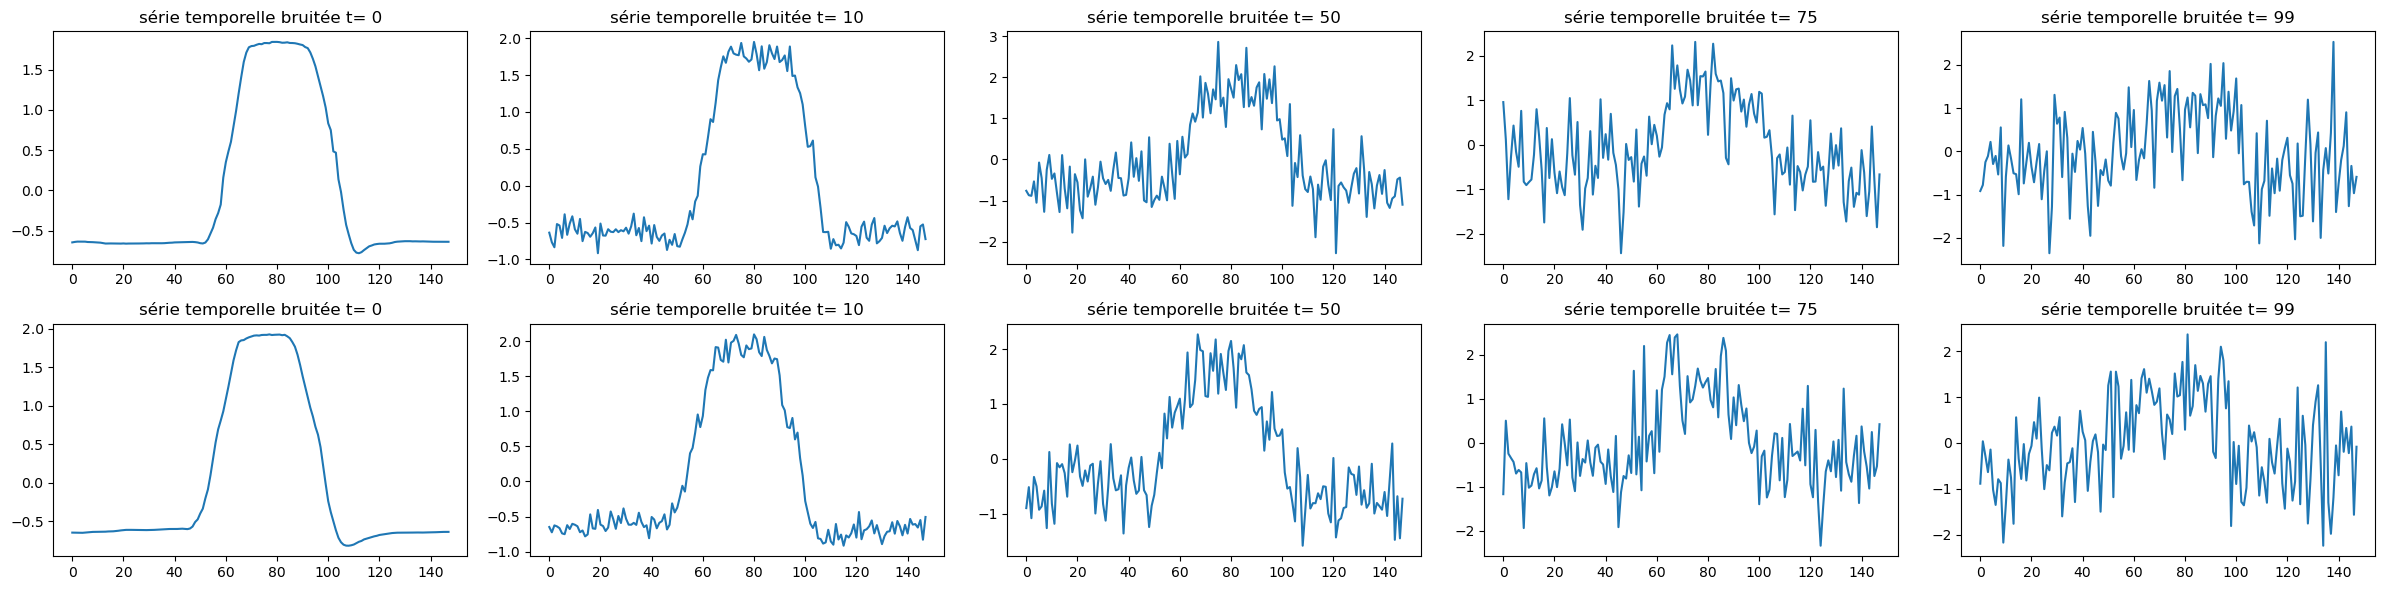

In [4]:
#nombre d'exemples de bruitages de série temporelle à visaliser
nb_example=2

time_series=x.iloc[range(nb_example)].to_numpy()

fig,ax=plt.subplots(nb_example,5,figsize=(24,3*nb_example))


for idx,lv in enumerate([0,config.timesteps//10,config.timesteps//2,config.timesteps*3//4,config.timesteps-1]):

    t = torch.tensor([lv])
    for line in range(nb_example):

        if lv==0:
            ax[line,0].plot(time_series[line])
        else:
            x_start = torch.as_tensor(trans_ts(time_series[line],v_min,v_max)).unsqueeze(0)
            res_sel=get_noisy_ts(x_start, t)
            ax[line,idx].plot(restore_ts(res_sel,v_min,v_max))
            
        ax[line,idx].set_title("série temporelle bruitée t= %i" % lv)
        
fig.tight_layout()
plt.savefig('diffusion_process.png')

On vérifie ici que le série la plus bruitée est bien similaire à une série aléatoirement générée

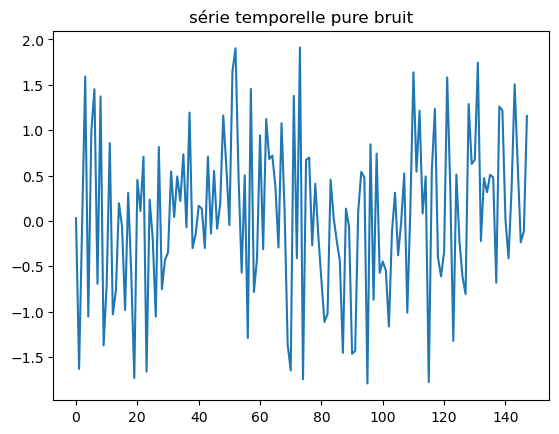

In [5]:
time_serie=time_series[0]
img = torch.randn(time_serie.shape)
plt.plot( torch.as_tensor(img))
plt.title("série temporelle pure bruit")
plt.show()

In [6]:
train=np.float32(x.to_numpy())
print(train.shape)
#Actuellement, train est un array de la forme (Nb_series,Nb_valeurs)

train=rearrange(train,"a b -> a 1 b")
#Dans la suite, nous souhaitons un array de la forme(Nb_series,Nb_channel,Nb_valeurs)

print(train.shape)
#Dans le cas de ces séries temporelles, nos données n'ont qu'un seul channel
#Dans le cas d'une image rgb par exemple, nos données auraient 3 channels 

(200, 148)
(200, 1, 148)


In [7]:
#pour tester l'effet de la normalisation actuellement implémentée
if(config.normalisation_test):
    
    transformed_train=trans_ts(train,v_min,v_max)
    restored_train=restore_ts(transformed_train,v_min,v_max)

    print("min max originaux :",(train.min(),train.max()))
    print("min max après transformation :",(transformed_train.min(),transformed_train.max()))
    print("min max après restauration :", (restored_train.min(),restored_train.max()))

    fig,ax=plt.subplots(3,5,figsize=(24,9))

    for idx in  range(5) :

        time_serie_example=train[idx][0]
        time_serie_example_transformed=transformed_train[idx][0]
        time_serie_example_restored=restored_train[idx][0]
        

        ax[0,idx].plot(time_serie_example)
        ax[0,idx].set_title("série temporelle %i" % idx)

        ax[1,idx].plot(time_serie_example_transformed)
        ax[1,idx].set_title("série temporelle %i normalisée" % idx)

        ax[2,idx].plot(time_serie_example_restored)
        ax[2,idx].set_title("série temporelle %i restorée" % idx)
            
    fig.tight_layout()
    plt.show  

In [8]:
if(config.normalisation_test):
    #On modifie train qui sera utilisé lors de l'entrainement du modèle
    train=transformed_train

#REMARQUE: Je ne crois pas que la normalisation a bien été implémentée,
#En tout cas elle ne semble pas dans son état actuel améliorer la qualité des résultats, ni être nécessaire 

In [9]:
dataloader=DataLoader(train, batch_size=batch_size, shuffle=True)
batch = next(iter(dataloader))
print(batch)

tensor([[[-0.6939, -0.6907, -0.6837,  ..., -0.5900, -0.5889, -0.5869]],

        [[-1.0370, -1.0375, -1.0373,  ..., -1.1504, -1.1502, -1.1529]],

        [[-0.6407, -0.6416, -0.6390,  ..., -0.7211, -0.7216, -0.7213]],

        ...,

        [[-0.6018, -0.6002, -0.5991,  ..., -0.6386, -0.6398, -0.6385]],

        [[-1.1896, -1.1919, -1.1847,  ..., -0.9226, -0.9322, -0.9497]],

        [[-1.1132, -1.1132, -1.1143,  ..., -1.1751, -1.1761, -1.1752]]])


In [10]:
from torch.optim import Adam

#vérifie qu'un GPU est disponible, sinon utilise le CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device utilisé :",device)

#On initisalise le modèle U-NET de débruitage
model = Unet(
    dim=config.ts_size,
    channels=config.channels,
    dim_mults=(1, 2, 4,),
    use_convnext=config.convnext,
    resnet_block_groups=config.resnetBlockGroups
)
model.to(device)

#On initialise l'otimizer Adam qui va controller l'évolution des parametres du NN
optimizer = Adam(model.parameters(), lr=1e-3)

device utilisé : cuda


In [11]:
training_start_time = datetime.now()
final_loss=-1
for epoch in range(config.epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      batch_size = batch.shape[0]
      batch = batch.to(device)

      # Tire des t aléatoirement entre 0 et timesteps, ce torseur de la forme (Batch_size) determine 
      # de combien de timestamps est ce que chaque série temporelle du batch sera perturbée
      # Correspond à la ligne 3 de l'algorithme 1 du papier DDPM
      t = torch.randint(0, config.timesteps, (batch_size,), device=device).long()

      # Le modèle de diffusion initial programmé s'attend à des batch de la forme (Nb_données,Nb_channels,Height,Width)
      # puisqu'il à été programmé pour des images. Pour apporter un minimum de modifications,
      # on considère dans la suite le séries temporelles comme une image de hauteur=Nombre de valeurs de la série 
      # temporelle, et de largeur=1 
      batch=rearrange(batch, "nb ch val-> nb ch val 1") #change le format du batch et rajoute une dimension width

      #calcule la loss pour ce batch
      loss = p_losses(model, batch, t, loss_type="huber")

      if step % 100 == 0:
        print("///////Epoch ",epoch," step ",step," Loss:", loss.item(),"/////////")
      
      if epoch==config.epochs-1:
         final_loss=loss.item()

      #met à jour le modèle
      loss.backward()
      
      #met à jour l'optimizer 
      optimizer.step()


=======================UNET--forward=======================
----for loop downs------
----start-bottleneck------
----for loop ups------
--------------------UNET--forward--end-------------------------
///////Epoch  0  step  0  Loss: 0.46580377221107483 /////////
=======================UNET--forward=======================
----for loop downs------
----start-bottleneck------
----for loop ups------
--------------------UNET--forward--end-------------------------
=======================UNET--forward=======================
----for loop downs------
----start-bottleneck------
----for loop ups------
--------------------UNET--forward--end-------------------------
=======================UNET--forward=======================
----for loop downs------
----start-bottleneck------
----for loop ups------
--------------------UNET--forward--end-------------------------
=======================UNET--forward=======================
----for loop downs------
----start-bottleneck------
----for loop ups------
-------

In [12]:
#Génère des données àléatoirement depuis le modèle entrainé
#Cette fonction correspond à la phase de sampling
samples = sample(model, image_size=config.ts_size, batch_size=5, channels=config.channels)

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

=======================UNET--forward=======================
----for loop downs------
----start-bottleneck------
----for loop ups------
--------------------UNET--forward--end-------------------------
=======================UNET--forward=======================
----for loop downs------
----start-bottleneck------
----for loop ups------
--------------------UNET--forward--end-------------------------
=======================UNET--forward=======================
----for loop downs------
----start-bottleneck------
----for loop ups------
--------------------UNET--forward--end-------------------------
=======================UNET--forward=======================
----for loop downs------
----start-bottleneck------
----for loop ups------
--------------------UNET--forward--end-------------------------
=======================UNET--forward=======================
----for loop downs------
----start-bottleneck------
----for loop ups------
--------------------UNET--forward--end-------------------------
=====

In [13]:
print("format de samples: liste %i batches, 1 pour chaque timestamp " % len(samples))
print("chaque élement de samples est de la forme",samples[0].shape)
#Ce format correspond à (Batch size,nb channel,nb valeur, 1)

format de samples: liste 100 batches, 1 pour chaque timestamp 
chaque élement de samples est de la forme (5, 1, 148, 1)


training loss : 0.049
training time: 02/07/2023 09:46:03
Epochs: 21
Convext: False
Batch Siz: 15
Image size: 148
Timesteps : 100
Down/Up Conv (k/s/p): (4, 2, 1)
Block Conv (k/p) : (3, 1)
RestNet Block Groups: 2
schedule: linear
normalisation: False
DataSet: GunPoint
Comment: 


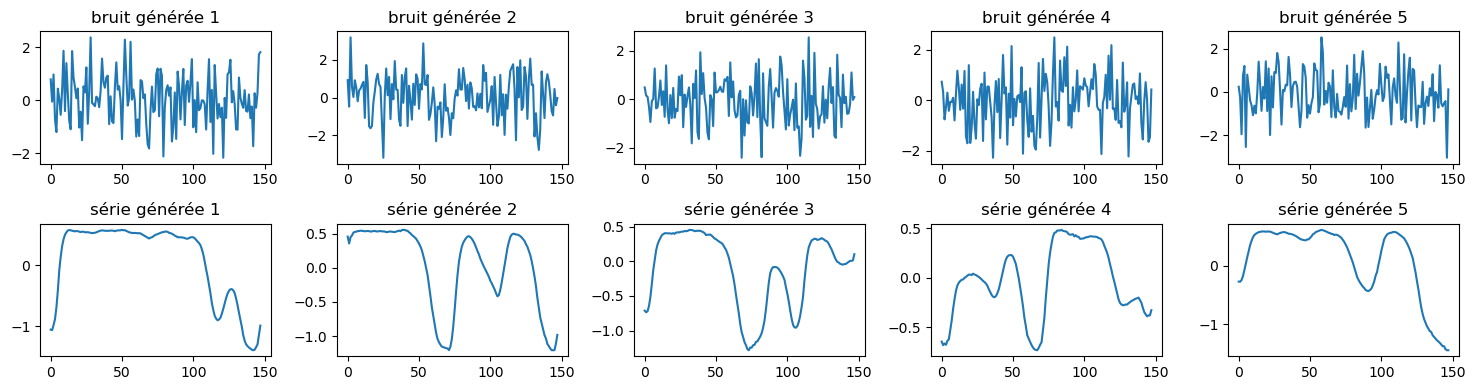

In [14]:
#afficher les résultats
fig,ax=plt.subplots(2,5,figsize=(15,4))

for idx in range(5):
  ax[0,idx].plot(restore_ts(samples[0][idx],v_min,v_max).squeeze(0))
  ax[0,idx].set_title("bruit générée %i"% (idx+1))
  
  ax[1,idx].plot(restore_ts(samples[-1][idx],v_min,v_max).squeeze(0))
  ax[1,idx].set_title("série générée %i"% (idx+1))

fig.tight_layout()


#parametres de l'apprentissage pour enregistrer les résultats et les conditions associées
parameters={"training loss ":float("{:.3f}".format(final_loss)),
            "training time":training_start_time.strftime("%m/%d/%Y %H:%M:%S"),
            "Epochs":config.epochs,
            "Convext":config.convnext,
            "Batch Siz":config.batch_size,
            "Image size":config.ts_size,
            "Timesteps ":config.timesteps,
            "Down/Up Conv (k/s/p)": (config.ConvKernelSize,config.ConvStrideSize,config.ConvPaddingSize),
            "Block Conv (k/p) ": (config.blockConvKernelSize,config.blockConvPadding),
            "RestNet Block Groups":config.resnetBlockGroups,
            "schedule":config.schedule,
            "normalisation":config.normalisation_test,
            "DataSet":config.dataset,
            "Comment":""
            }

for str in parameters.keys():
  print(str+":",parameters[str])

if(True):
  
  #add log of the result
  with open('generated_ts/trials.txt', 'a') as file:
    file.write(json.dumps(parameters))
    file.write("\n")

  fig.savefig("generated_ts/version_"+training_start_time.strftime("%m-%d-%Y_%H-%M-%S"))

  

Sur le batch de taille 5 généré, on a 5 séries temporelles. Pour chacune, on part d'un tensor avec des valeurs choisies aléatoirement, c'est des séries temporelles correspondant à du bruit. On parcourt le modèle U-NET entrainé pour qu'il estime le bruitage à chaque étape (timestep) et on utilise cette estimation pour néttoyer itérativement les série temporelles.

Ci dessous une animation du processus de génération d'une série temporelle du batch

MovieWriter ffmpeg unavailable; using Pillow instead.


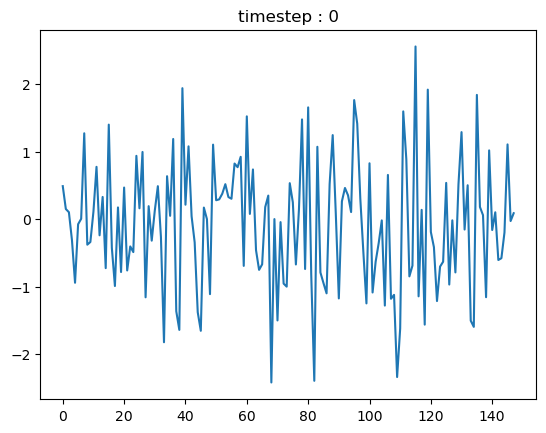

In [15]:
idx_toPlot=2 #index de la série temporelle du batch à visualiser

fig, ax = plt.subplots()

nbFrames=100 #nombre d'images dans l'animation
tmpInterval=100 #intervalle en milisecondes entre chaque image de l'animation

# function that draws each frame of the animation
def animate(i):
    #determiner le timestep à afficher pour chaque frame
    step=i*config.timesteps//(nbFrames+1) 

    ax.clear()
    ax.set_title("timestep : %i" % step)
    ax.plot(restore_ts(samples[step][idx_toPlot],v_min,v_max).squeeze(0))

ani = FuncAnimation(fig, animate, frames=nbFrames, interval=tmpInterval, repeat=False)

ani.save('time_serie_generation.gif')

A titre de comparaison, ci-dessous les séries temporelles de la base de donnée originale

<function matplotlib.pyplot.show(close=None, block=None)>

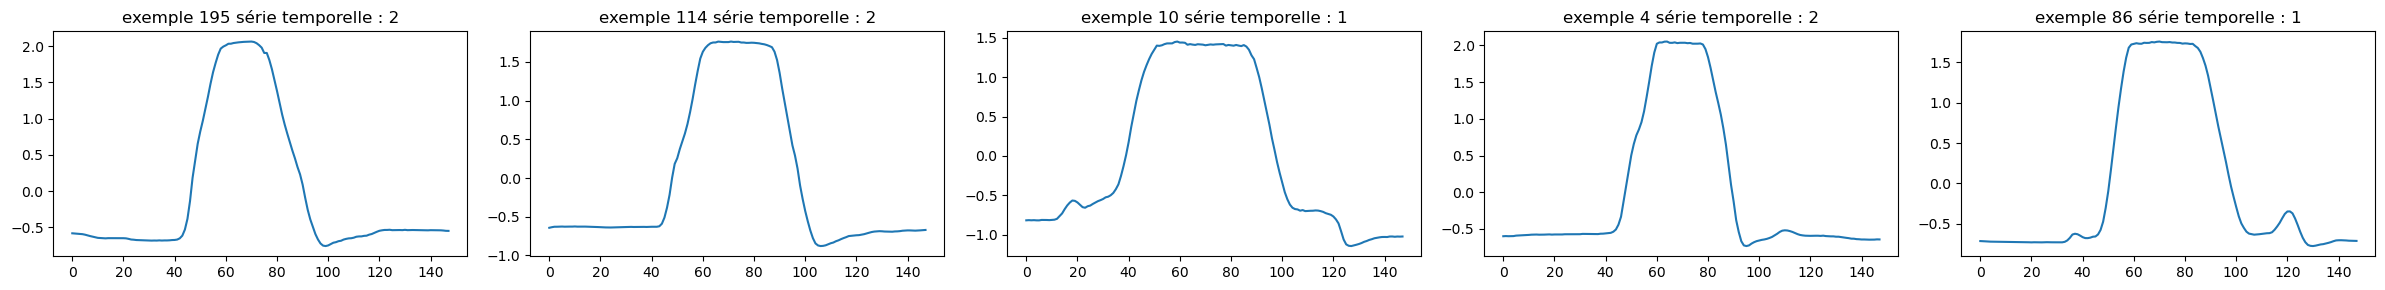

In [16]:
fig,ax=plt.subplots(1,5,figsize=(24,3))

for idx,st in enumerate([ random.randint(0,len(x)) for  i in range(5) ]):

    time_serie_example=x.iloc[[st]].to_numpy()[0]

    ax[idx].plot(time_serie_example)
    ax[idx].set_title("exemple %i série temporelle : %i" % (st,y.iloc[st]))
        
fig.tight_layout()
plt.show

#ATTENTION pour GunPoint les séries temporelles 68 67 100 154 sont différentes des autres
# Cas particuliers ? erreurs ? normal ? Compter ou non dans l'aprentissage ? jsp 

Comme observé, les résultats ne sont pas réellement ressemblants aux données de la base d'apprentissage. 

Nous vérifions maintenant les capacités de débruitage uniquement du modèle entrainé. Nous partons des séries temporelles de la base d'aprentissage que nous allons bruiter puis débruiter pour vérifier qu'on obtient bien nos données d'origine, ou du moins des séries temporelles similaires. 

In [17]:
test_noise_level=config.timesteps//2
print("noise level :",test_noise_level)

#noise level
t = torch.tensor([test_noise_level]*5,device=device).long()

#batch
my_batch=batch.cpu().numpy()
my_batch=restore_ts(my_batch,v_min,v_max)

#batch bruité
batch_noisy=q_sample(batch,t)
my_batch_noisy=batch_noisy.cpu().numpy()
my_batch_noisy=restore_ts(my_batch_noisy,v_min,v_max)


#batch débruité
img = batch_noisy
imgs = []

for i in reversed(range(0, test_noise_level)):
        img = p_sample(model, img, torch.full((5,), i, device=device, dtype=torch.long), i)
        imgs.append(restore_ts(img.cpu().numpy(),v_min,v_max))


noise level : 50
=======================UNET--forward=======================
----for loop downs------
----start-bottleneck------
----for loop ups------
--------------------UNET--forward--end-------------------------
=======================UNET--forward=======================
----for loop downs------
----start-bottleneck------
----for loop ups------
--------------------UNET--forward--end-------------------------
=======================UNET--forward=======================
----for loop downs------
----start-bottleneck------
----for loop ups------
--------------------UNET--forward--end-------------------------
=======================UNET--forward=======================
----for loop downs------
----start-bottleneck------
----for loop ups------
--------------------UNET--forward--end-------------------------
=======================UNET--forward=======================
----for loop downs------
----start-bottleneck------
----for loop ups------
--------------------UNET--forward--end--------------

<function matplotlib.pyplot.show(close=None, block=None)>

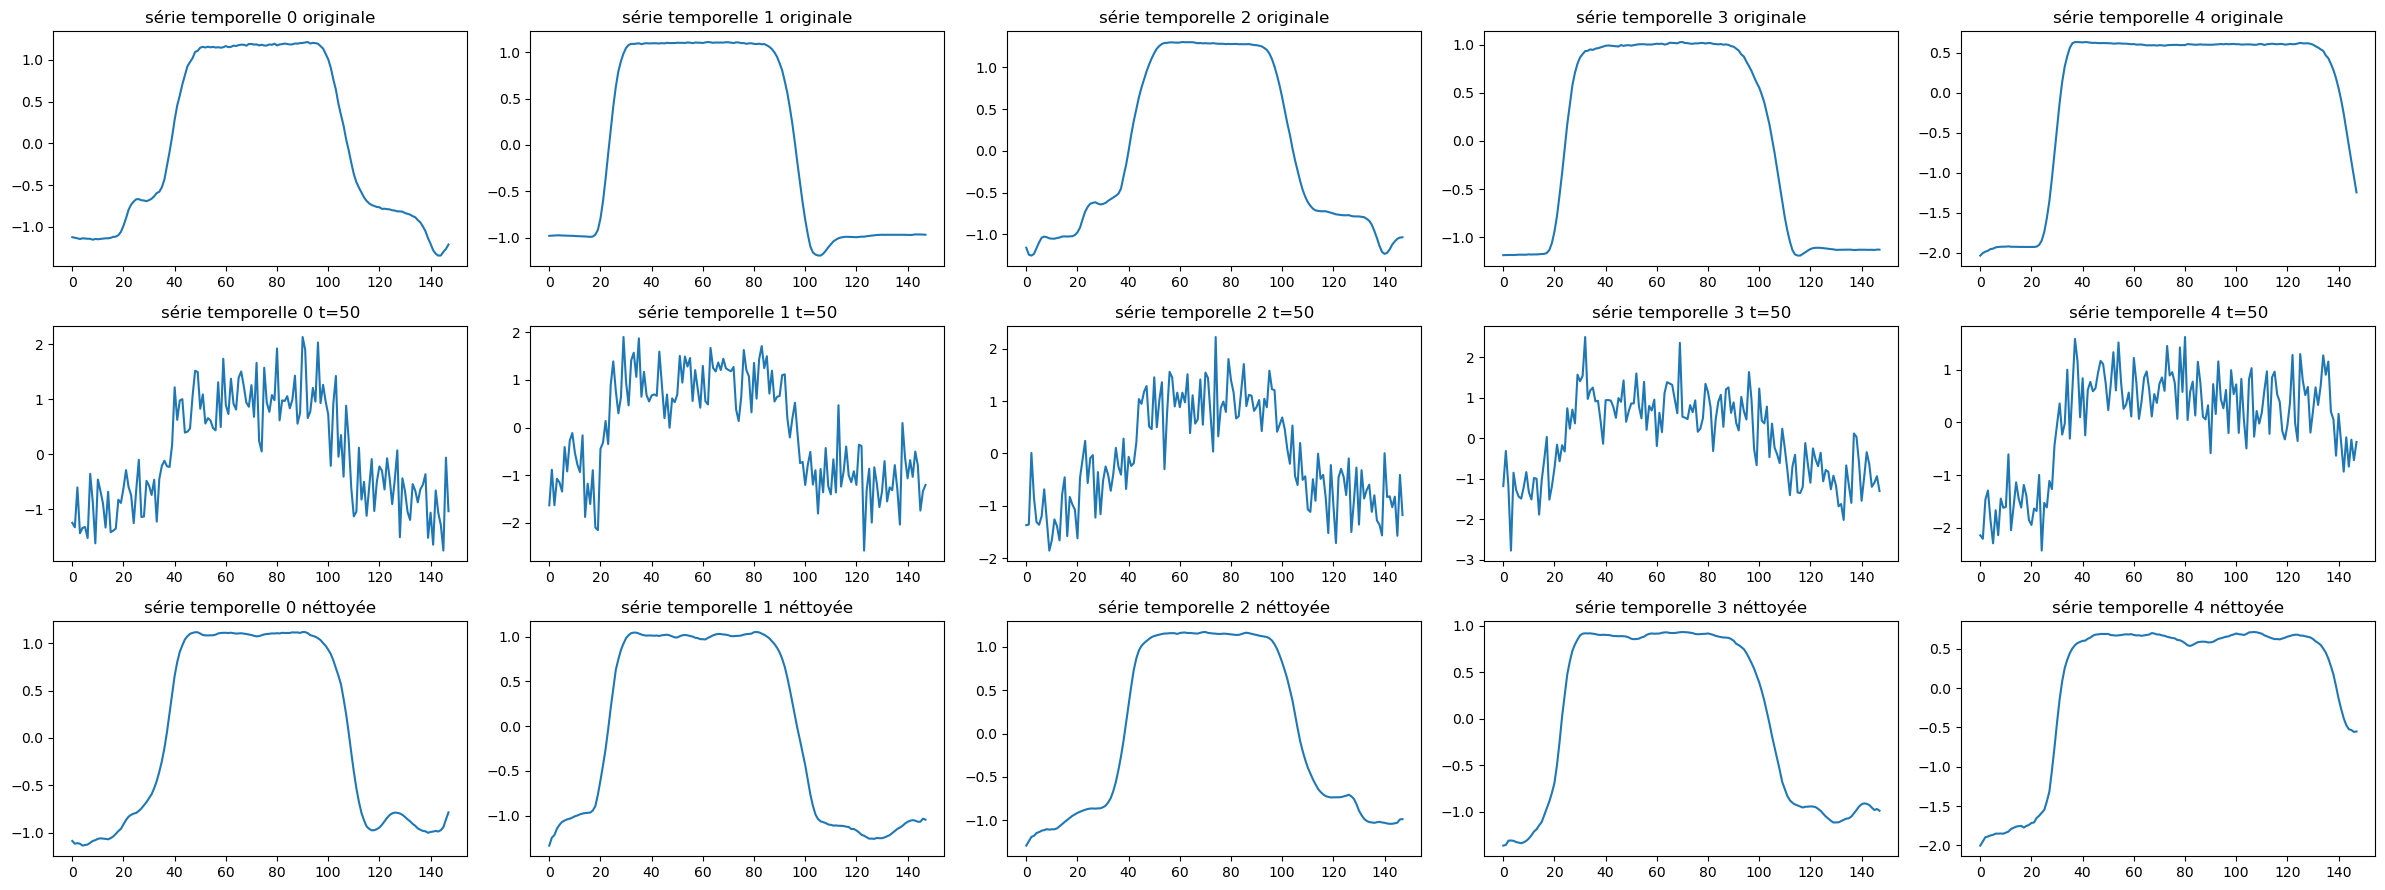

In [18]:
fig,ax=plt.subplots(3,5,figsize=(24,9))

for idx in range(5):
    
    st=my_batch[idx][0]
    st_noisy=my_batch_noisy[idx][0]
    st_cleaned=imgs[-1][idx][0]

    ax[0,idx].plot(st)
    ax[0,idx].set_title("série temporelle %i originale" % idx)

    ax[1,idx].plot(st_noisy)
    ax[1,idx].set_title("série temporelle %i t=%i" % (idx,t[idx]))

    ax[2,idx].plot(st_cleaned)
    ax[2,idx].set_title("série temporelle %i néttoyée" % idx)

fig.tight_layout()
plt.show

Ceci est la partie la plus intéressante dans le cadre de la génération de contrefactuelles. L'hypothèse serait de partie d'une donnée X, de la bruiter, et ensuite débruiter avec une certaine classe visée. Il faut réfléchir à comment intégrer le classifieur qu'on souhaite expliquer, ainsi que les classes query et target dans ce système. 